In [1]:
'''
Nicole Osayande
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Data Preprocessing

In [2]:
#import dataset
#investigating marital status and overall cognition
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_totalcomp_uncorrected','married_or_livingtogether','abcd_site','site_id_l','race_ethnicity'], index_col=False)


In [3]:
#change categorical variable to numerical
data['married_or_livingtogether'].replace(['no','yes'],
                        [0,1], inplace=True)

In [4]:
data['nihtbx_totalcomp_uncorrected_log']= np.log(data['nihtbx_totalcomp_uncorrected'])
col='nihtbx_totalcomp_uncorrected_log'
data['nihtbx_totalcomp_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0)

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [6]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
tp = data.married_or_livingtogether.values
target_values = data.nihtbx_totalcomp_uncorrected_zscore.values

In [7]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
tp_ = shared(tp)

# Run Model

In [8]:
#varying intercepts and varying slopes: 
#predicting overall cognition scores from parental marital status 

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    # yhat = varying state-intercept + varying race-slope*SDV
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * tp_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 1150 seconds.
The number of effective samples is smaller than 25% for some parameters.


# Model Statistics

Text(0.5, 1.0, 'marital status model of overall cognition')

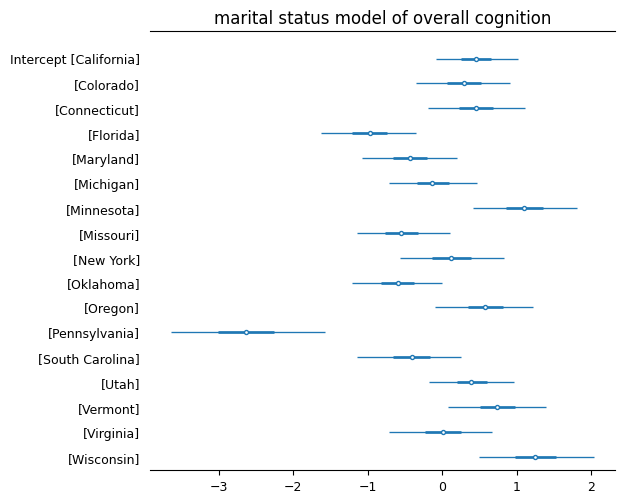

In [9]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("marital status model of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
#fig.savefig('forest_plot_state_intercept_marry_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_13176/4191615672.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Text(0.5, 1.0, 'marital status slope effects of overall cognition')

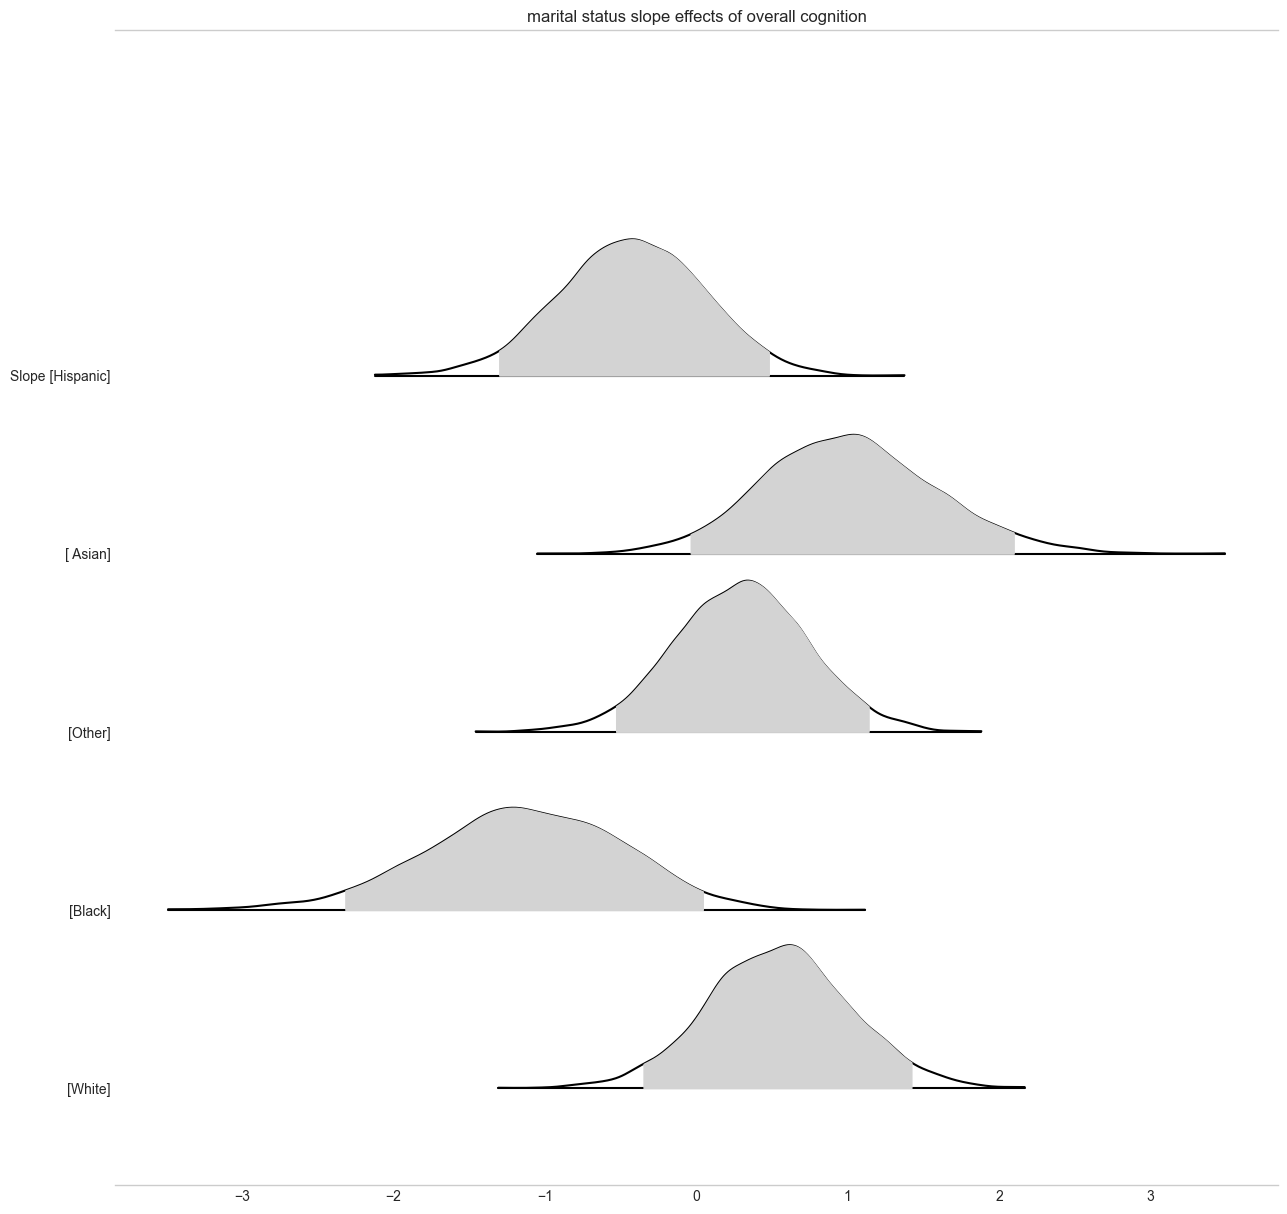

In [10]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("marital status slope effects of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
#fig.savefig('forest_ridge_plot_race_slope_marry_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [11]:
# posterior predictive check
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [12]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.367247
r2_std    0.003522
dtype: float64

# Visualizing predictions

plots at the bottom

In [13]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [14]:
# get race, state and parental marital status columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_tp_df = pd.DataFrame(data['married_or_livingtogether'],columns =['married_or_livingtogether']).reset_index(drop=True)


In [15]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_tp_df,ppc_df,left_index=True, right_index=True)


In [16]:
ppc_tp_race_mean = (ppc_df.groupby(['married_or_livingtogether','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_tp_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
married_or_livingtogether race_ethnicity                                 
0                         Asian          -0.331899 -0.258908 -0.786963   
                          Black          -0.435841 -0.462401 -0.497162   
                          Hispanic       -0.408333 -0.389958 -0.499320   
                          Other          -0.441846 -0.428545 -0.448519   
                          White          -0.417479 -0.379576 -0.396089   
1                         Asian           0.571090  0.648382  0.495850   
                          Black          -0.525061 -0.597311 -0.615798   
                          Hispanic       -0.185449 -0.182531 -0.195884   
                          Other           0.206473  0.111533  0.147183   
                          White           0.331212  0.311037  0.313549   

                                          pp_cog_3  pp_cog_4  pp_cog_5  \
married_or_livingtogether race_ethnicity                                 
0                         Asian          -0.168908 -0.448933 -0.437203   
                          Black          -0.430910 -0.458490 -0.498755   
                          Hispanic       -0.383957 -0.324595 -0.423198   
                          Other          -0.409356 -0.298908 -0.463553   
                          White          -0.408343 -0.334539 -0.320116   
1                         Asian           0.428983  0.514619  0.527169   
                          Black          -0.628338 -0.516813 -0.549542   
                          Hispanic       -0.146903 -0.159611 -0.172277   
                          Other           0.156154  0.178892  0.123448   
                          White           0.340132  0.334538  0.286998   

                                          pp_cog_6  pp_cog_7  pp_cog_8  \
married_or_livingtogether race_ethnicity                                 
0                         Asian          -0.111538 -0.247848 -0.732438   
                          Black          -0.517039 -0.485986 -0.454636   
                          Hispanic       -0.336750 -0.403206 -0.355577   
                          Other          -0.441723 -0.492448 -0.461709   
                          White          -0.410428 -0.344043 -0.386974   
1                         Asian           0.463573  0.527856  0.619115   
                          Black          -0.535664 -0.538307 -0.637150   
                          Hispanic       -0.189395 -0.190193 -0.174138   
                          Other           0.174084  0.112654  0.167207   
                          White           0.313867  0.328061  0.328980   

                                          pp_cog_9  ...  pp_cog_7990  \
married_or_livingtogether race_ethnicity            ...                
0                         Asian          -0.045756  ...    -0.470406   
                          Black          -0.451803  ...    -0.500970   
                          Hispanic       -0.458472  ...    -0.383174   
                          Other          -0.458890  ...    -0.460219   
                          White          -0.428151  ...    -0.340884   
1                         Asian           0.567383  ...     0.618193   
                          Black          -0.601142  ...    -0.673032   
                          Hispanic       -0.096968  ...    -0.198253   
                          Other           0.145572  ...     0.202550   
                          White           0.332549  ...     0.301896   

                                          pp_cog_7991  pp_cog_7992  \
married_or_livingtogether race_ethnicity                             
0                         Asian             -0.172966    -0.151417   
                          Black             -0.524680    -0.490273   
                          Hispanic          -0.323481    -0.328972   
                          Other             -0.414281    -0.363686   
                          White             -0.383823    -0.415989   
1                   

In [17]:
ppc_tp_race_mean_summ=ppc_tp_race_mean.mean(axis=1)
ppc_tp_race_mean_summ

married_or_livingtogether  race_ethnicity
0                          Asian            -0.332028
                           Black            -0.470961
                           Hispanic         -0.380543
                           Other            -0.415078
                           White            -0.372556
1                          Asian             0.555064
                           Black            -0.606374
                           Hispanic         -0.174301
                           Other             0.164677
                           White             0.311442
dtype: float64

In [18]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.487268,0.564161,0.376771,0.373482,0.425176,0.437649,0.410187,0.455849,0.493655,0.510467,...,0.517141,0.477289,0.572490,0.436908,0.484599,0.623527,0.607223,0.425826,0.527925,0.341572
Black,-0.470022,-0.514085,-0.542612,-0.506546,-0.480834,-0.518212,-0.524174,-0.506030,-0.524558,-0.509015,...,-0.566888,-0.551784,-0.558267,-0.499011,-0.550886,-0.530963,-0.524072,-0.576232,-0.487403,-0.587774
Hispanic,-0.252835,-0.245244,-0.287624,-0.218573,-0.209492,-0.248139,-0.233946,-0.254595,-0.228994,-0.206264,...,-0.254161,-0.180452,-0.206702,-0.235409,-0.180073,-0.269416,-0.234526,-0.199540,-0.235095,-0.220541
Other,0.025334,-0.039364,-0.019255,-0.001849,0.045395,-0.040560,0.002028,-0.056411,-0.008511,-0.023314,...,0.017374,-0.028535,0.000437,-0.003007,0.019380,-0.057636,0.017033,-0.032980,0.019563,-0.006680
White,0.218356,0.206936,0.206580,0.227309,0.233683,0.195484,0.204689,0.226750,0.221059,0.217883,...,0.205005,0.175862,0.206406,0.215292,0.211541,0.189132,0.179680,0.211891,0.194929,0.211999


In [19]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [20]:
ppc_tp_state_mean = (ppc_df.groupby(['married_or_livingtogether','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_tp_state_mean_summ = ppc_tp_state_mean.mean(axis=1)


In [21]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [22]:
ppc_tp_state_mean_summ_list=ppc_tp_state_mean_summ.to_numpy()
low_tp_state = ppc_tp_state_mean_summ_list[:17]
high_tp_state = ppc_tp_state_mean_summ_list[-17:]

In [23]:
mean_predictions_state = [low_tp_state,high_tp_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.296895,-0.321269,-0.295337,-0.538192,-0.446468,-0.396007,-0.187617,-0.467280,-0.352942,-0.474927,-0.275113,-0.820308,-0.442992,-0.304875,-0.248225,-0.371492,-0.161185
1,0.128524,0.217758,0.205241,-0.187897,0.002195,0.130283,0.403046,0.022411,0.176851,0.011380,0.296373,-0.495501,0.052014,0.293242,0.386939,0.117913,0.414224


In [24]:
ppc_tp_race_mean_summ_list=ppc_tp_race_mean_summ.to_numpy()
low_tp_race = ppc_tp_race_mean_summ_list[:5]
high_tp_race = ppc_tp_race_mean_summ_list[-5:]

In [25]:
# initialize list of lists 
mean_predictions_race = [low_tp_race,high_tp_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,-0.332028,-0.470961,-0.380543,-0.415078,-0.372556
1,0.555064,-0.606374,-0.174301,0.164677,0.311442


# Poststratification Steps

In [26]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','Single_Parent_Fam_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [27]:
#binarizing input variable
val = census_data['Single_Parent_Fam_score'].median()
census_data.loc[census_data['Single_Parent_Fam_score'] < val, 'Single_Parent_Fam_score_bin'] = 1
census_data.loc[census_data['Single_Parent_Fam_score'] >= val, 'Single_Parent_Fam_score_bin'] = 0

In [28]:
#get the population frequencies for all state x race x SDV subgroup
census = (census_data.groupby(['state','race_ethnicity','Single_Parent_Fam_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq
0,california,Asian,0.0,1066853
1,california,Asian,1.0,768462
2,california,Black,0.0,786431
3,california,Black,1.0,3168044
4,california,Hispanic,0.0,2979380
...,...,...,...,...
139,wisconsin,Hispanic,1.0,44759
140,wisconsin,Other,0.0,168524
141,wisconsin,Other,1.0,14993
142,wisconsin,White,0.0,1875561


In [29]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,1066853,1,0
1,california,Asian,1.0,768462,1,0
2,california,Black,0.0,786431,3,0
3,california,Black,1.0,3168044,3,0
4,california,Hispanic,0.0,2979380,0,0


In [30]:
#fix theano shared tensor type error
census=census.astype({'Single_Parent_Fam_score_bin':'uint8'})

In [31]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_tp = census.Single_Parent_Fam_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
tp_.set_value(ps_tp)

In [32]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [33]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(144, 8000)

In [34]:
censust=census
censust

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,race_enc,state_enc
0,california,Asian,0,1066853,1,0
1,california,Asian,1,768462,1,0
2,california,Black,0,786431,3,0
3,california,Black,1,3168044,3,0
4,california,Hispanic,0,2979380,0,0
...,...,...,...,...,...,...
139,wisconsin,Hispanic,1,44759,0,16
140,wisconsin,Other,0,168524,2,16
141,wisconsin,Other,1,14993,2,16
142,wisconsin,White,0,1875561,4,16


In [35]:
# get race, state, and parental marital status  columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_tp_df2 = pd.DataFrame(censust['Single_Parent_Fam_score_bin'],columns =['Single_Parent_Fam_score_bin']).reset_index(drop=True)


In [36]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_tp_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,1066853,-0.009070,-0.121072,0.237938,-0.474685,-0.264531,-2.083159,...,-0.512575,-0.934195,-0.845395,-0.033075,-0.923906,0.672516,0.131542,-0.399394,0.628055,-1.102315
1,california,Asian,1,768462,1.565600,-1.172521,2.068084,0.954561,-0.923820,1.605236,...,0.601871,1.871753,1.437334,0.891352,1.300604,0.837130,1.521161,1.055466,0.646916,-0.184940
2,california,Black,0,786431,0.393549,-0.308561,-0.555452,-1.732075,0.824887,1.817171,...,-0.099158,-0.851908,-0.648466,-0.289935,0.303192,-0.588743,0.463747,-0.400677,-0.617506,-0.881499
3,california,Black,1,3168044,-1.805926,-2.125906,-2.127865,-0.634493,-0.455408,0.125133,...,0.060208,-1.174092,-0.002760,-1.437203,-1.955641,-0.049337,-0.728949,-2.491358,-0.599824,0.590035
4,california,Hispanic,0,2979380,-1.698250,0.544401,-0.649779,-0.275143,-0.875844,-1.971287,...,0.102774,-1.908615,-0.492435,0.842809,-0.676902,0.369212,-0.328821,-1.130223,0.979504,-0.988533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,wisconsin,Hispanic,1,44759,-0.646491,0.143318,0.053490,-0.586670,1.031435,0.194872,...,-0.137703,-0.111592,-1.223988,-1.912762,-0.420455,-0.651634,0.257789,-0.635790,0.491517,1.143373
140,wisconsin,Other,0,168524,-0.431302,-0.877353,0.736691,0.107253,-0.009963,0.425579,...,-0.190700,-0.831497,1.714109,-1.243636,0.324347,0.011170,0.989407,0.524075,-1.019099,1.950211
141,wisconsin,Other,1,14993,-0.319745,-0.561307,-0.122072,2.352642,-1.171990,1.119059,...,-0.269434,0.353032,-1.696177,0.138704,0.253614,1.321437,0.991901,0.111388,0.897010,1.303355
142,wisconsin,White,0,1875561,0.291892,0.891219,-1.419648,0.248793,-1.338343,-0.573563,...,-0.079922,0.760480,-0.940182,-0.342815,0.424521,0.246850,-1.238436,1.089401,1.246639,-0.696929


In [37]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','Single_Parent_Fam_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0   -9.675847e+03   
                          1                           1    1.203104e+06   
           Black          0                           2    3.094992e+05   
                          1                           3   -5.721252e+06   
           Hispanic       0                           4   -5.059731e+06   
...                                                                 ...   
wisconsin  Hispanic       1                           139 -2.893628e+04   
           Other          0                           140 -7.268473e+04   
                          1                           141 -4.793933e+03   
           White          0                           142  5.474604e+05   
                          1                           143  4.185266e+05   

                                                               pp_cog_1  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0   -1.291656e+05   
                          1                           1   -9.010379e+05   
           Black          0                           2   -2.426617e+05   
                          1                           3   -6.734963e+06   
           Hispanic       0                           4    1.621977e+06   
...                                                                 ...   
wisconsin  Hispanic       1                           139  6.414757e+03   
           Other          0                           140 -1.478551e+05   
                          1                           141 -8.415674e+03   
           White          0                           142  1.671536e+06   
                          1                           143  2.672887e+06   

                                                               pp_cog_2  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0    2.538445e+05   
                          1                           1    1.589244e+06   
           Black          0                           2   -4.368245e+05   
                          1                           3   -6.741170e+06   
           Hispanic       0                           4   -1.935940e+06   
...                                                                 ...   
wisconsin  Hispanic       1                           139  2.394138e+03   
           Other          0                           140  1.241501e+05   
                          1                           141 -1.830232e+03   
           White          0                           142 -2.662636e+06   
                          1                           143  2.893554e+06   

                                                               pp_cog_3  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0   -5.064192e+05   
                          1                           1    7.335438e+05   
           Black          0                           2   -1.362158e+06   
                          1                           3   -2.010101e+06   
           Hispanic       0                           4   -8.197550e+05   
...                                                                 ...   
wisconsin  Hispanic       1                           139 -2.625876e+04   
           Other          0                           140  1.807464e+04   
                          1                           141  3.527316e+04   
           White          0                           142  4.666269e+05   
                          1                           143  3.234275e+05   

                                                               pp_cog_4  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
californi

In [38]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-9.675847e+03,-1.291656e+05,2.538445e+05,-5.064192e+05,-2.822162e+05,-2.222425e+06,-7.756935e+05,3.242259e+05,9.498930e+05,2.133215e+06,...,-5.468421e+05,-9.966492e+05,-9.019117e+05,-3.528577e+04,-9.856720e+05,7.174754e+05,1.403359e+05,-4.260949e+05,6.700420e+05,-1.176008e+06
1,1.203104e+06,-9.010379e+05,1.589244e+06,7.335438e+05,-7.099207e+05,1.233563e+06,1.266954e+06,-4.446147e+04,8.466264e+05,1.746188e+06,...,4.625151e+05,1.438371e+06,1.104536e+06,6.849703e+05,9.994644e+05,6.433026e+05,1.168955e+06,8.110856e+05,4.971304e+05,-1.421190e+05
2,3.094992e+05,-2.426617e+05,-4.368245e+05,-1.362158e+06,6.487164e+05,1.429079e+06,-1.177309e+06,-5.236749e+05,-1.056039e+06,-5.201119e+05,...,-7.798118e+04,-6.699670e+05,-5.099737e+05,-2.280135e+05,2.384393e+05,-4.630061e+05,3.647052e+05,-3.151045e+05,-4.856263e+05,-6.932382e+05
3,-5.721252e+06,-6.734963e+06,-6.741170e+06,-2.010101e+06,-1.442753e+06,3.964261e+05,-7.499913e+05,4.603137e+06,1.218384e+06,4.878516e+06,...,1.907418e+05,-3.719574e+06,-8.745362e+03,-4.553122e+06,-6.195558e+06,-1.563009e+05,-2.309343e+06,-7.892731e+06,-1.900267e+06,1.869258e+06
4,-5.059731e+06,1.621977e+06,-1.935940e+06,-8.197550e+05,-2.609473e+06,-5.873214e+06,2.082888e+06,-3.955307e+05,1.664028e+06,-4.315195e+06,...,3.062024e+05,-5.686489e+06,-1.467150e+06,2.511049e+06,-2.016749e+06,1.100022e+06,-9.796824e+05,-3.367365e+06,2.918316e+06,-2.945215e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-2.893628e+04,6.414757e+03,2.394138e+03,-2.625876e+04,4.616601e+04,8.722284e+03,5.376259e+04,1.650881e+04,1.938702e+04,1.926057e+04,...,-6.163448e+03,-4.994753e+03,-5.478447e+04,-8.561332e+04,-1.881916e+04,-2.916648e+04,1.153838e+04,-2.845733e+04,2.199981e+04,5.117623e+04
140,-7.268473e+04,-1.478551e+05,1.241501e+05,1.807464e+04,-1.678965e+03,7.172030e+04,-1.388157e+05,-2.354033e+05,-3.029427e+05,-4.641995e+05,...,-3.213750e+04,-1.401272e+05,2.888686e+05,-2.095826e+05,5.466020e+04,1.882417e+03,1.667388e+05,8.831923e+04,-1.717426e+05,3.286574e+05
141,-4.793933e+03,-8.415674e+03,-1.830232e+03,3.527316e+04,-1.757164e+04,1.677805e+04,1.608456e+04,1.222210e+04,1.156615e+04,1.266977e+04,...,-4.039622e+03,5.293007e+03,-2.543078e+04,2.079592e+03,3.802432e+03,1.981231e+04,1.487157e+04,1.670038e+03,1.344888e+04,1.954120e+04
142,5.474604e+05,1.671536e+06,-2.662636e+06,4.666269e+05,-2.510145e+06,-1.075752e+06,-5.654574e+06,-5.241766e+05,-7.940220e+04,-2.671557e+05,...,-1.498983e+05,1.426326e+06,-1.763369e+06,-6.429698e+05,7.962154e+05,4.629814e+05,-2.322762e+06,2.043239e+06,2.338147e+06,-1.307134e+06


In [39]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq
0,california,Asian,0,1066853
1,california,Asian,1,768462
2,california,Black,0,786431
3,california,Black,1,3168044
4,california,Hispanic,0,2979380
...,...,...,...,...
139,wisconsin,Hispanic,1,44759
140,wisconsin,Other,0,168524
141,wisconsin,Other,1,14993
142,wisconsin,White,0,1875561


In [40]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,1066853,-9.675847e+03,-1.291656e+05,2.538445e+05,-5.064192e+05,-2.822162e+05,-2.222425e+06,...,-5.468421e+05,-9.966492e+05,-9.019117e+05,-3.528577e+04,-9.856720e+05,7.174754e+05,1.403359e+05,-4.260949e+05,6.700420e+05,-1.176008e+06
1,california,Asian,1,768462,1.203104e+06,-9.010379e+05,1.589244e+06,7.335438e+05,-7.099207e+05,1.233563e+06,...,4.625151e+05,1.438371e+06,1.104536e+06,6.849703e+05,9.994644e+05,6.433026e+05,1.168955e+06,8.110856e+05,4.971304e+05,-1.421190e+05
2,california,Black,0,786431,3.094992e+05,-2.426617e+05,-4.368245e+05,-1.362158e+06,6.487164e+05,1.429079e+06,...,-7.798118e+04,-6.699670e+05,-5.099737e+05,-2.280135e+05,2.384393e+05,-4.630061e+05,3.647052e+05,-3.151045e+05,-4.856263e+05,-6.932382e+05
3,california,Black,1,3168044,-5.721252e+06,-6.734963e+06,-6.741170e+06,-2.010101e+06,-1.442753e+06,3.964261e+05,...,1.907418e+05,-3.719574e+06,-8.745362e+03,-4.553122e+06,-6.195558e+06,-1.563009e+05,-2.309343e+06,-7.892731e+06,-1.900267e+06,1.869258e+06
4,california,Hispanic,0,2979380,-5.059731e+06,1.621977e+06,-1.935940e+06,-8.197550e+05,-2.609473e+06,-5.873214e+06,...,3.062024e+05,-5.686489e+06,-1.467150e+06,2.511049e+06,-2.016749e+06,1.100022e+06,-9.796824e+05,-3.367365e+06,2.918316e+06,-2.945215e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,wisconsin,Hispanic,1,44759,-2.893628e+04,6.414757e+03,2.394138e+03,-2.625876e+04,4.616601e+04,8.722284e+03,...,-6.163448e+03,-4.994753e+03,-5.478447e+04,-8.561332e+04,-1.881916e+04,-2.916648e+04,1.153838e+04,-2.845733e+04,2.199981e+04,5.117623e+04
140,wisconsin,Other,0,168524,-7.268473e+04,-1.478551e+05,1.241501e+05,1.807464e+04,-1.678965e+03,7.172030e+04,...,-3.213750e+04,-1.401272e+05,2.888686e+05,-2.095826e+05,5.466020e+04,1.882417e+03,1.667388e+05,8.831923e+04,-1.717426e+05,3.286574e+05
141,wisconsin,Other,1,14993,-4.793933e+03,-8.415674e+03,-1.830232e+03,3.527316e+04,-1.757164e+04,1.677805e+04,...,-4.039622e+03,5.293007e+03,-2.543078e+04,2.079592e+03,3.802432e+03,1.981231e+04,1.487157e+04,1.670038e+03,1.344888e+04,1.954120e+04
142,wisconsin,White,0,1875561,5.474604e+05,1.671536e+06,-2.662636e+06,4.666269e+05,-2.510145e+06,-1.075752e+06,...,-1.498983e+05,1.426326e+06,-1.763369e+06,-6.429698e+05,7.962154e+05,4.629814e+05,-2.322762e+06,2.043239e+06,2.338147e+06,-1.307134e+06


In [41]:
#final step of poststratification - by race & marital status 
#data-weighted average
ppc_tp_race_poststrat = ppc_poststrat_df.groupby(['Single_Parent_Fam_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_tp_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
Single_Parent_Fam_score_bin race_ethnicity                                 
0                           Asian           0.232895  0.179455 -0.998268   
                            Black          -0.810911 -0.533163 -1.489827   
                            Hispanic       -0.675890 -0.357058 -0.473166   
                            Other          -0.510771 -1.108563 -0.793894   
                            White          -0.554924 -0.636758 -0.862497   
1                           Asian           0.001827  0.515697  0.120229   
                            Black          -0.886390 -0.793958 -1.407531   
                            Hispanic       -0.975317  1.369913 -0.049124   
                            Other           0.548870  0.273813 -0.100811   
                            White           0.418622  0.234887 -0.224043   

                                            pp_cog_3  pp_cog_4  pp_cog_5  \
Single_Parent_Fam_score_bin race_ethnicity                                 
0                           Asian           0.140966 -0.690491  0.506825   
                            Black          -1.061723 -0.739387 -0.336952   
                            Hispanic        0.183138 -0.996606 -0.818297   
                            Other           0.137179  0.477760 -0.748789   
                            White          -0.396497 -0.566771 -0.562670   
1                           Asian           0.644758  0.323049  0.518943   
                            Black          -0.647048 -0.448407 -0.332292   
                            Hispanic       -0.842458  0.511110 -0.262600   
                            Other          -1.070468  0.920655 -0.058238   
                            White           0.417904 -0.103920  0.613016   

                                            pp_cog_6  pp_cog_7  pp_cog_8  \
Single_Parent_Fam_score_bin race_ethnicity                                 
0                           Asian          -0.677362 -0.697118 -0.356898   
                            Black          -1.023473 -0.498253 -0.669818   
                            Hispanic       -0.259384  0.271201 -0.302618   
                            Other           0.641186 -0.928602 -0.578556   
                            White          -0.282430 -0.200206 -0.292744   
1                           Asian           0.087444  0.731919  0.260281   
                            Black          -0.552686 -0.350556 -0.109391   
                            Hispanic       -0.329924 -0.451212 -0.378058   
                            Other          -0.348254  0.171683  0.640986   
                            White          -0.020597  0.147692  0.362067   

                                            pp_cog_9  ...  pp_cog_7990  \
Single_Parent_Fam_score_bin race_ethnicity            ...                
0                           Asian          -0.358943  ...     0.312731   
                            Black          -0.484470  ...    -0.550132   
                            Hispanic       -0.825579  ...    -0.461302   
                            Other          -0.791632  ...    -0.722327   
                            White          -0.674400  ...     0.182294   
1                           Asian           0.365741  ...     0.160328   
                            Black           0.098277  ...    -0.004929   
                            Hispanic       -0.852436  ...    -0.238727   
                            Other          -0.125999  ...     0.396264   
                            White           0.370112  ...    -0.124064   

                                            pp_cog_7991  pp_cog_7992  \
Single_Parent_Fam_score_bin race_ethnicity                             
0                           Asian             -0.553839    -0.905395   
                            Black             -0.045443    -0.172894   
                            Hispanic          -0.393468    -0.675497   
                            Other             -0.560744 

In [42]:
#summarize race & marital status poststrat results
ppc_tp_race_poststrat_summ = ppc_tp_race_poststrat.mean(axis=1)
ppc_tp_race_poststrat_summ

Single_Parent_Fam_score_bin  race_ethnicity
0                            Asian            -0.371918
                             Black            -0.429500
                             Hispanic         -0.417953
                             Other            -0.377192
                             White            -0.403239
1                            Asian             0.435992
                             Black            -0.536996
                             Hispanic         -0.149620
                             Other             0.069618
                             White             0.260987
dtype: float64

In [43]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian      -0.049737
Black      -0.484286
Hispanic   -0.314162
Other      -0.203682
White      -0.151542
dtype: float64

In [44]:
#for the lollipop plots
#final step poststrat - by state & marital status
ppc_tp_state_poststrat = ppc_poststrat_df.groupby(['Single_Parent_Fam_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_tp_state_poststrat_summ = ppc_tp_state_poststrat.mean(axis=1)
ppc_tp_state_poststrat_summ

Single_Parent_Fam_score_bin  state        
0                            california      -0.304114
                             colorado        -0.319109
                             connecticut     -0.301498
                             florida         -0.538299
                             maryland        -0.437840
                             michigan        -0.406587
                             minnesota       -0.187242
                             missouri        -0.464030
                             newyork         -0.341924
                             oklahoma        -0.485798
                             oregon          -0.272758
                             pennsylvania    -0.823671
                             southcarolina   -0.444385
                             utah            -0.306180
                             vermont         -0.252506
                             virginia        -0.377983
                             wisconsin       -0.159837
1                     

In [45]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california      -0.162188
colorado        -0.189135
connecticut     -0.090983
florida         -0.345917
maryland        -0.412400
michigan        -0.318066
minnesota       -0.040860
missouri        -0.333082
newyork         -0.129002
oklahoma        -0.384969
oregon          -0.092804
pennsylvania    -0.600350
southcarolina   -0.367679
utah             0.154920
vermont          0.119746
virginia        -0.075461
wisconsin        0.111180
dtype: float64

In [46]:
ppc_tp_state_poststrat_summ_list=ppc_tp_state_poststrat_summ.tolist()

In [47]:
#fill in missing value for connecticut
ppc_tp_state_poststrat_summ_list.insert(19,ppc_tp_state_mean_summ.iloc[19])

In [48]:
low_tp_state_poststrat = ppc_tp_state_poststrat_summ_list[:17]
high_tp_state_poststrat = ppc_tp_state_poststrat_summ_list[-17:]

In [49]:
ppc_tp_race_poststrat_summ_list=ppc_tp_race_poststrat_summ.tolist()

In [50]:
low_tp_race_poststrat = ppc_tp_race_poststrat_summ_list[:5]
high_tp_race_poststrat = ppc_tp_race_poststrat_summ_list[-5:]

In [51]:
mean_predictions_state_ps = [low_tp_state_poststrat,high_tp_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.304114,-0.319109,-0.301498,-0.538299,-0.437840,-0.406587,-0.187242,-0.464030,-0.341924,-0.485798,-0.272758,-0.823671,-0.444385,-0.306180,-0.252506,-0.377983,-0.159837
1,-0.031333,0.205241,0.221131,-0.014101,-0.384744,-0.151849,0.394758,0.097368,0.162440,0.086181,0.131268,-0.291040,-0.026154,0.205852,0.400630,0.151565,0.462612


In [52]:
# initialize list of lists 
mean_predictions_race_ps = [low_tp_race_poststrat,high_tp_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,-0.371918,-0.429500,-0.417953,-0.377192,-0.403239
1,0.435992,-0.536996,-0.149620,0.069618,0.260987


In [53]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

#quantiles_state,quantiles_state_ps

In [54]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

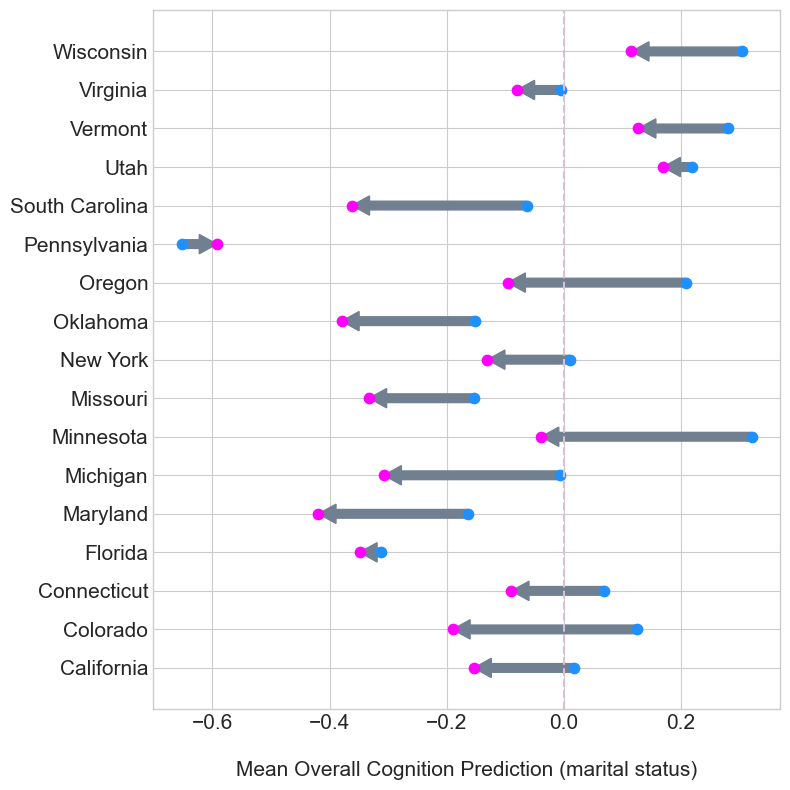

In [55]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (marital status)',size=15,labelpad=20)
#plt.title('Mean Predictions of overall Cognition based on Marital Status Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
#plt.savefig('arrow_plot_marry_overall_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [56]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

#quantiles_race,quantiles_race_ps

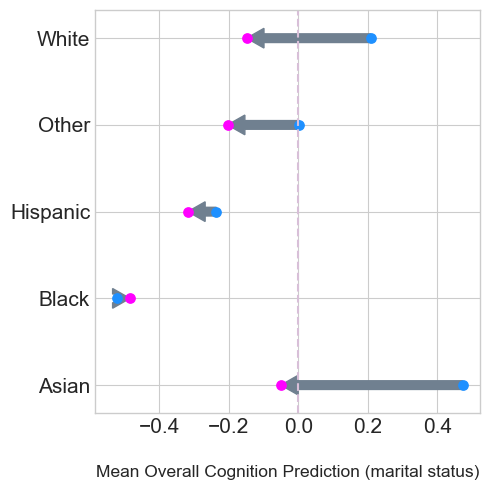

In [57]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (marital status)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of overall Cognition based on Marital Status Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
#plt.savefig('arrow_plot_marry_overall_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_13176/1226274042.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_13176/1226274042.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


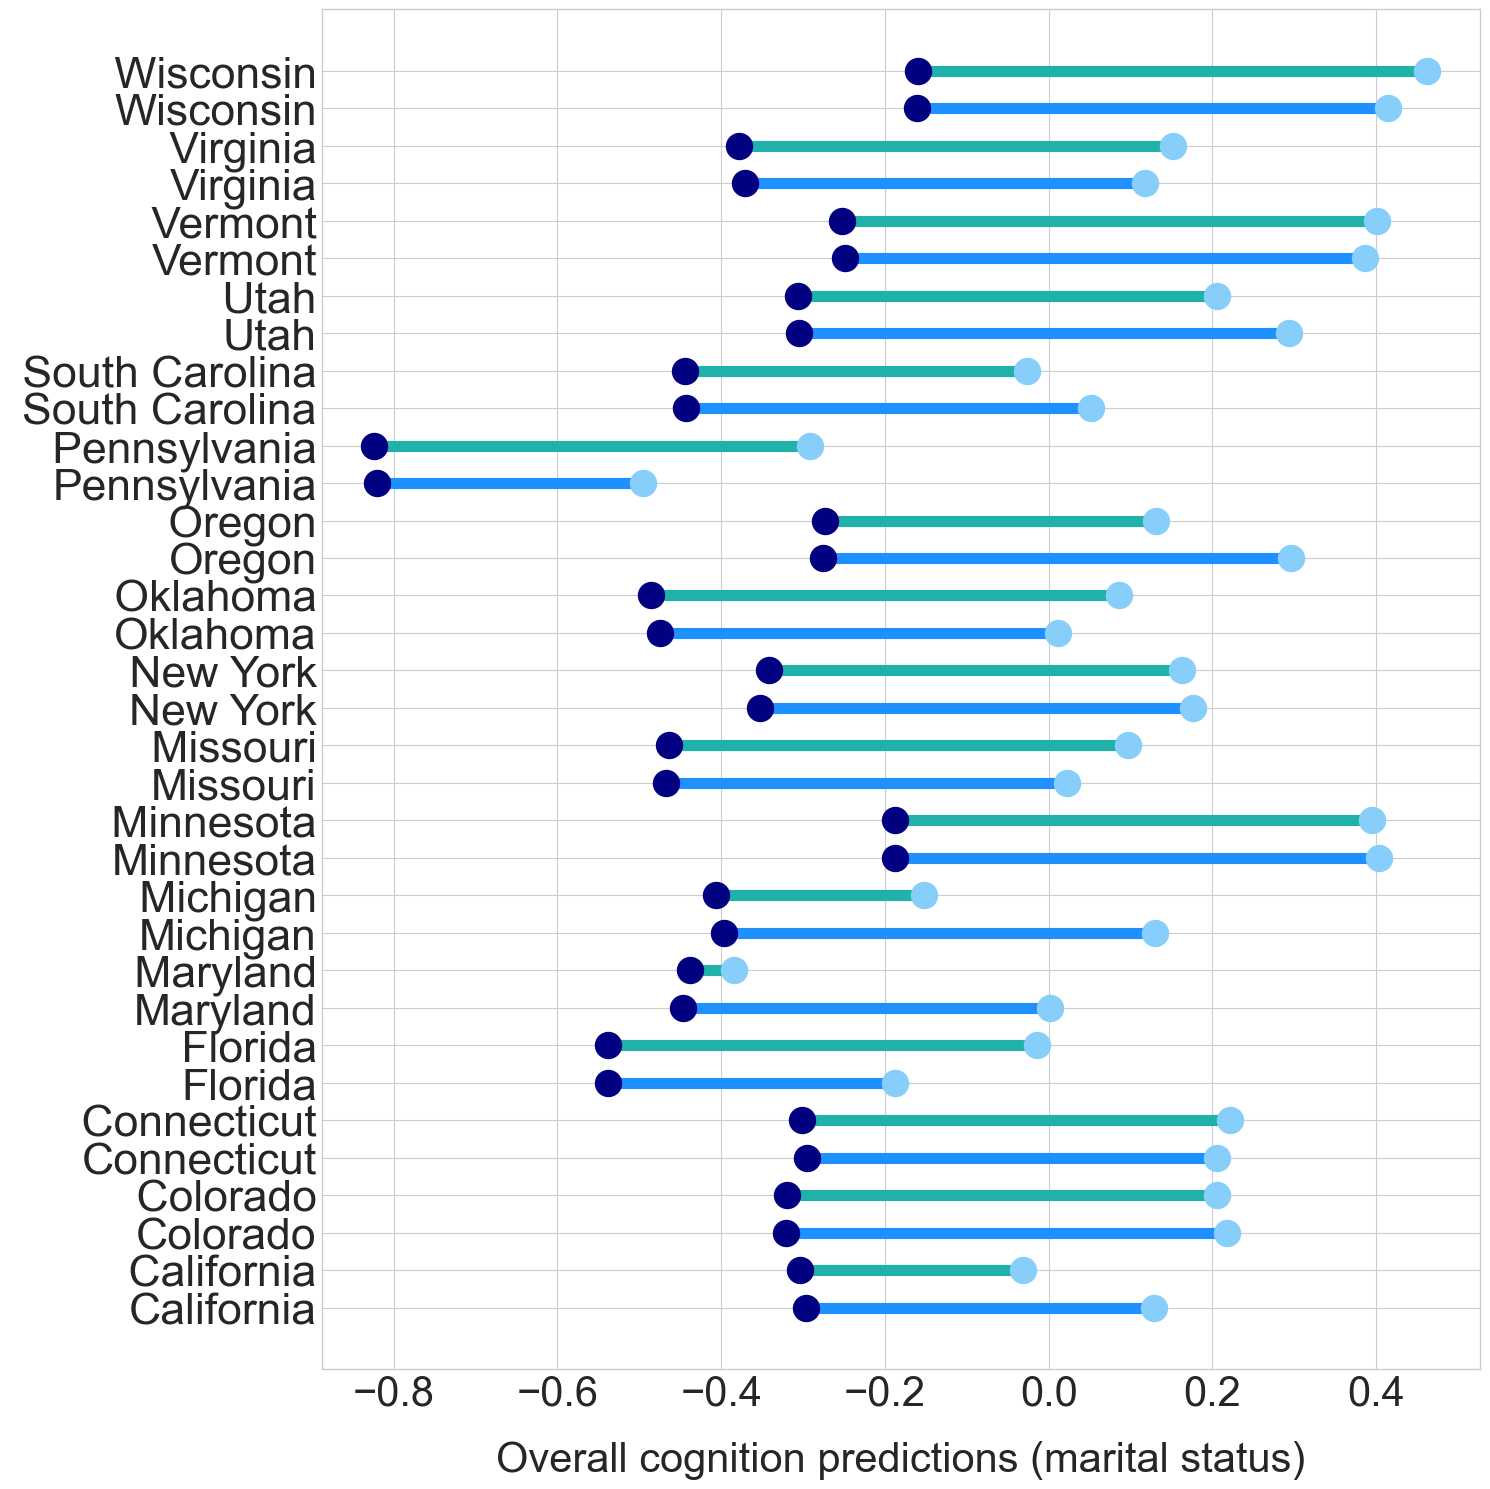

In [58]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='navy', label='sp HH', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='lightskyblue', label='tp HH', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='navy', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='lightskyblue', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (marital status)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','tp HH', 'sp HH'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
#plt.savefig('lolli_plot_marry_overall_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_13176/984831505.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_13176/984831505.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


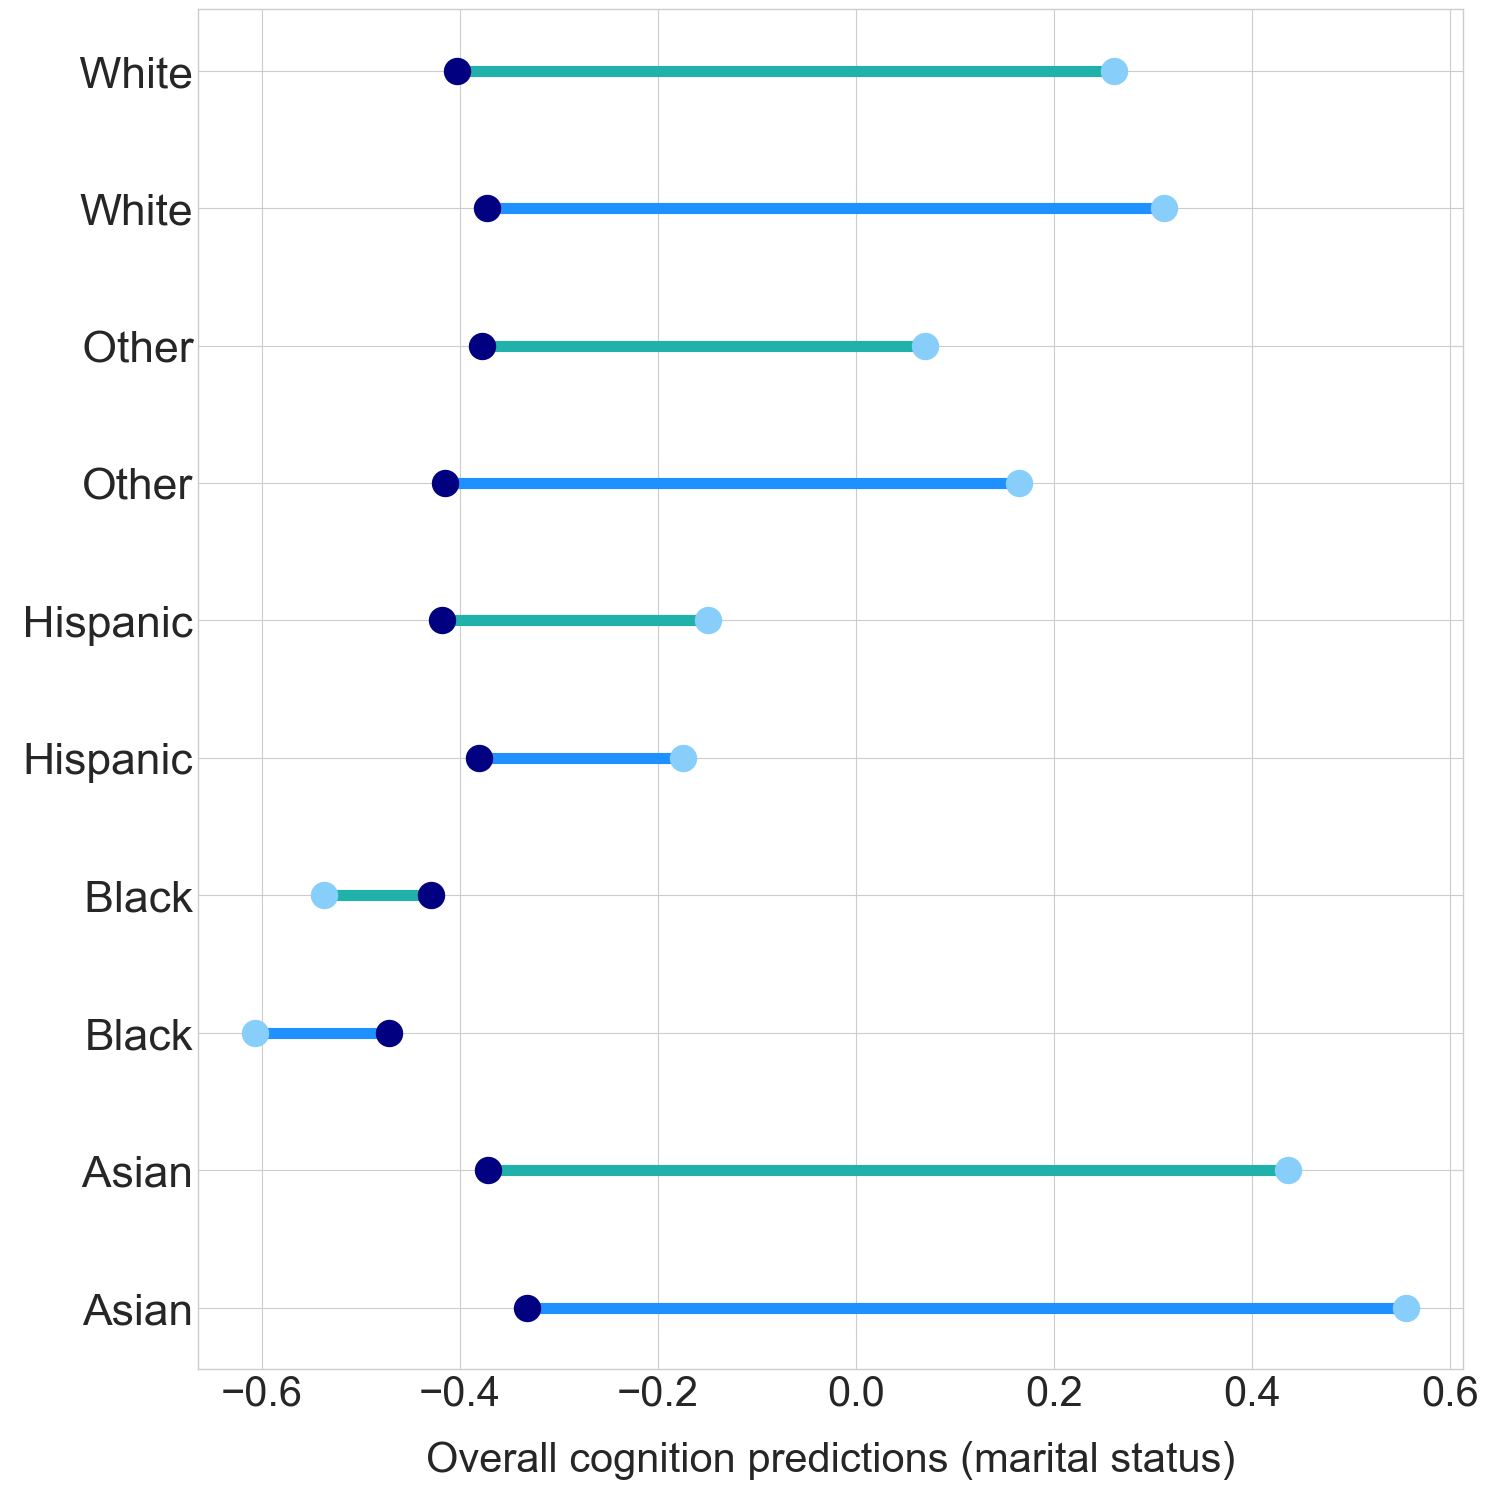

In [59]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='navy', label='sp HH', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='lightskyblue', label='tp HH', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='navy', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='lightskyblue', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (marital status)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','sp HH', 'tp HH'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
#plt.savefig('lolli_plot_marry_overall_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()